In [1]:
import json
import os
from os.path import join
from pathlib import Path

import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
from dn_utils.plotting import plot_matrix
from dn_utils.networks import networks_mean

%matplotlib inline

/home/kmb/Desktop/Neuroscience/Projects/BONNA_decide_net/code/dn_utils/glm_utils.py:13: FutureWarning: 

 | Starting with Nilearn 0.7.0, all Nistats functionality has been incorporated into Nilearn's stats & reporting modules.
 | Nistats package will no longer be updated or maintained.

  from nistats import design_matrix


In [2]:
path_root = os.environ.get("DECIDENET_PATH")

path_derivatives = join(path_root, "data/main_fmri_study/derivatives")
path_sourcedata = join(path_root, "data/main_fmri_study/sourcedata") 

path_bsc = join(path_derivatives, "bsc")
path_nistats = join(path_derivatives, "nistats")
path_parcellations = join(path_derivatives, "parcellations")

path_corrmats = join(path_bsc, "corrmats")

## Settings

In [3]:
atlas = "combined_roi"
alpha_fdr = 1e-8
n_nulls = 200

In [4]:
# Additional paths
alpha_fdr_str = str(alpha_fdr).replace("-", "")
path_fdrthr = join(path_corrmats, f"{atlas}/fdrthr_{alpha_fdr_str}")
path_nulls = join(path_fdrthr, "nulls")

# Load correlation matrices and metadata
corrmats_aggregated = np.load(join(path_corrmats, atlas, 
                                   "corrmats_aggregated.npy"))
with open(join(path_corrmats, atlas, "corrmats_aggregated.json"), "r") as f:
    meta = json.loads(f.read())

# Load subject exclusion
df_exclusion = pd.read_csv(join(path_nistats, "exclusion/exclusion.csv"), 
                           index_col=0)
ok_index = df_exclusion["ok_all"]    
    
# Load ROI information
df_roi = pd.read_csv(join(path_corrmats, atlas, "roi_table_filtered.csv"))
    
n_subjects = len(meta["dim1"])
n_conditions = len(meta["dim2"])
n_perr_sign = len(meta["dim3"])
n_rois = len(df_roi)
n_nets = len(df_roi["netName"].unique())

# Load & aggreagte null networks
nulls_aggregated = np.zeros(
    (n_subjects, n_conditions, n_perr_sign, n_nulls, n_nets, n_nets))

for sub_idx, sub in enumerate(meta["dim1"]):
    for con_idx, con in enumerate(meta["dim2"]):
        for perr_sign_idx, perr_sign in enumerate(meta["dim3"]):
            fname = f"sub-{sub}_task-prl{con}_perrsign-{perr_sign[-3:]}" + \
                     "_nullmeanmats.npy"
            nulls_aggregated[sub_idx, con_idx, perr_sign_idx] = np.load(
                join(path_nulls, fname))
            
print("nulls_aggregated.shape:", nulls_aggregated.shape)

nulls_aggregated.shape: (32, 2, 2, 200, 15, 15)


In [5]:
# Calculate real LSN interactions
lsn_aggregated = np.zeros(
    (n_subjects, n_conditions, n_perr_sign, n_nets, n_nets))

for sub_idx, sub in enumerate(meta["dim1"]):
    for con_idx, con in enumerate(meta["dim2"]):
        for perr_sign_idx, perr_sign in enumerate(meta["dim3"]):
            corrmat = corrmats_aggregated[sub_idx, con_idx, perr_sign_idx]
            netnames, lsn_aggregated[sub_idx, con_idx, perr_sign_idx] = networks_mean(
                corrmat, df_roi["netName"])

print("lsn_aggregated.shape:", lsn_aggregated.shape)

lsn_aggregated.shape: (32, 2, 2, 15, 15)


## Four separate conditions

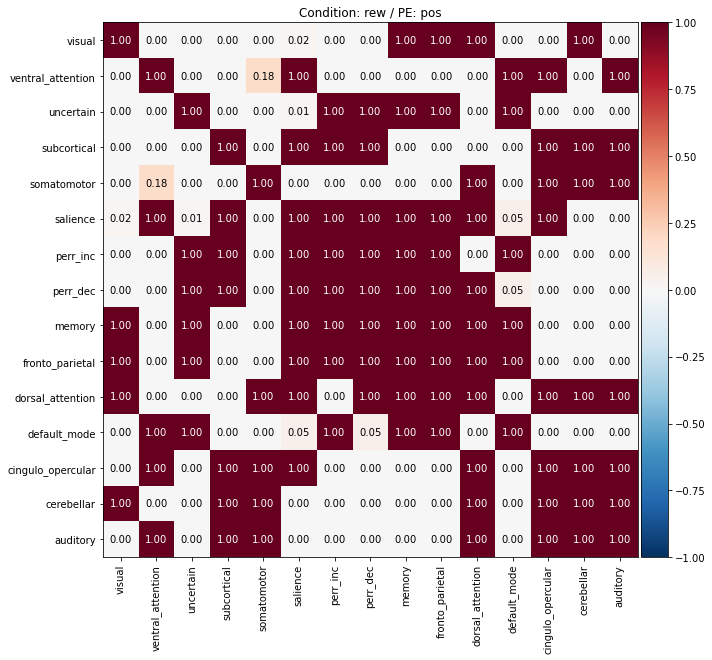

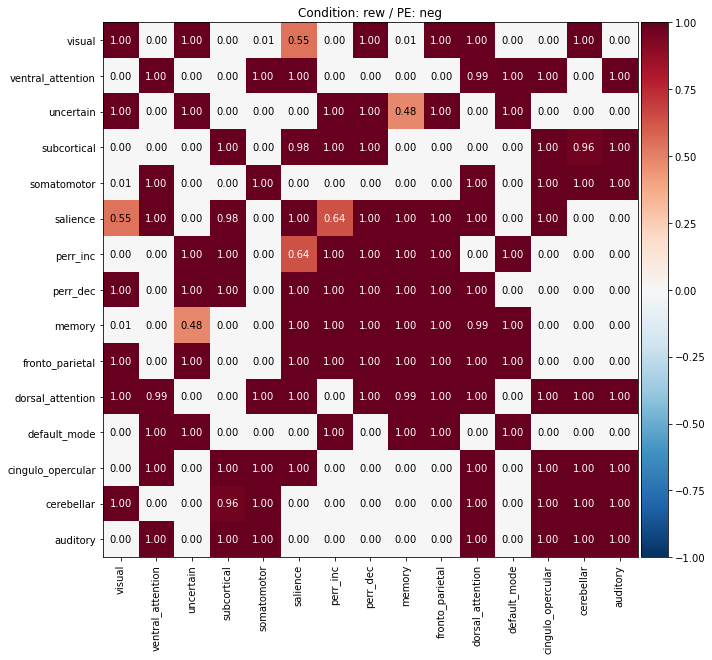

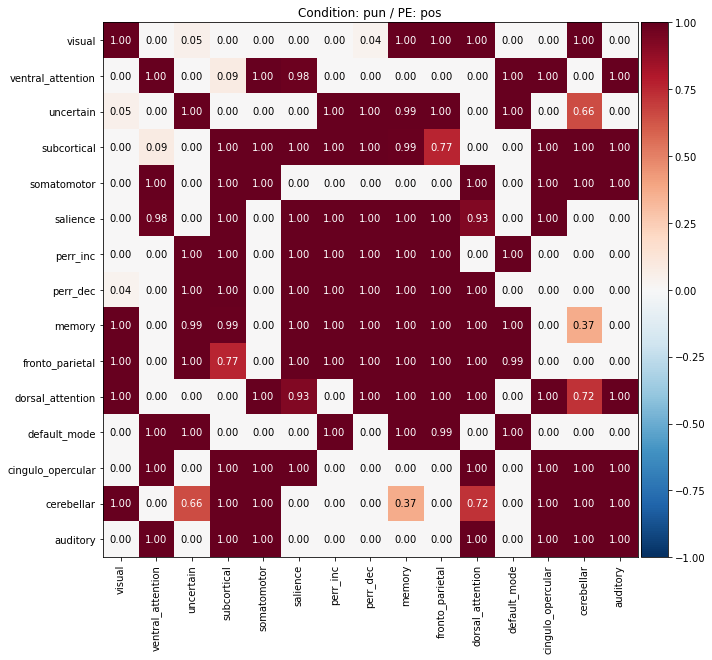

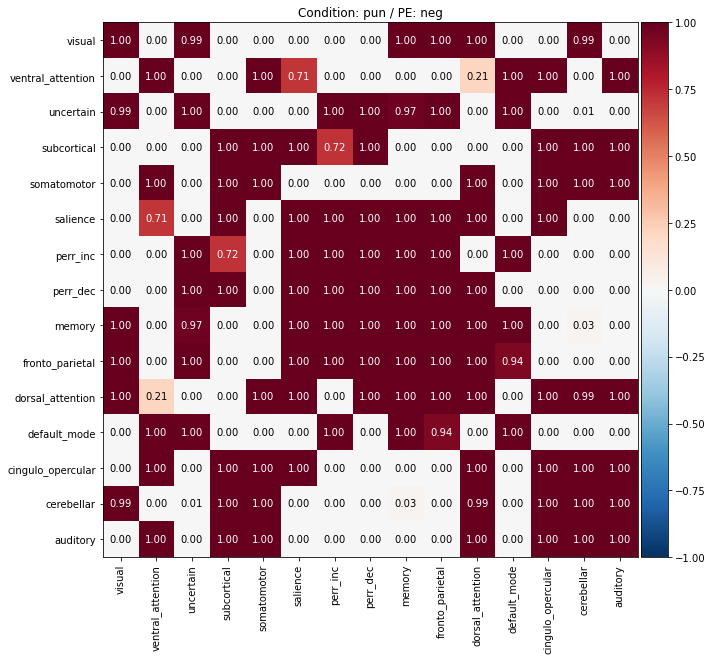

In [6]:
gtnull = np.mean(lsn_aggregated[ok_index], axis=0) \
       > np.swapaxes(np.mean(nulls_aggregated[ok_index], axis=0), 0, 2)
gtnull = np.sum(gtnull, axis=0)
gtnull = gtnull / n_nulls

for con_idx, con in enumerate(meta["dim2"]):
    for perr_sign_idx, perr_sign in enumerate(meta["dim3"]):
        plot_matrix(
            gtnull[con_idx, perr_sign_idx], 
            labels=netnames, 
            annotate=True, 
            title=f"Condition: {con} / PE: {perr_sign[-3:]}"
        )

## Mean over single condition class

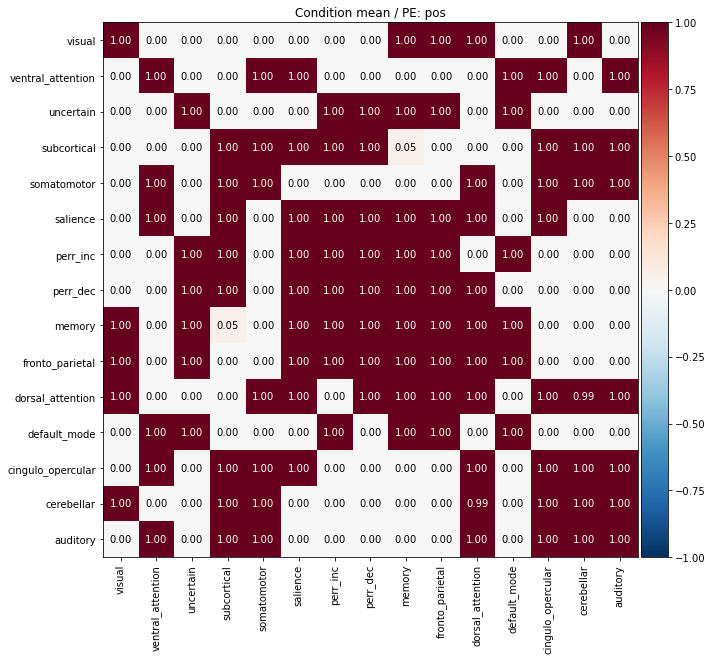

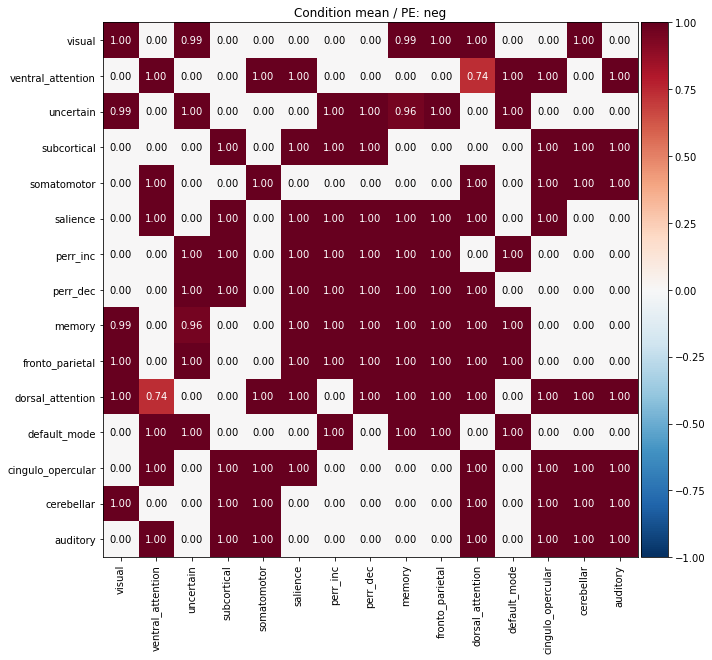

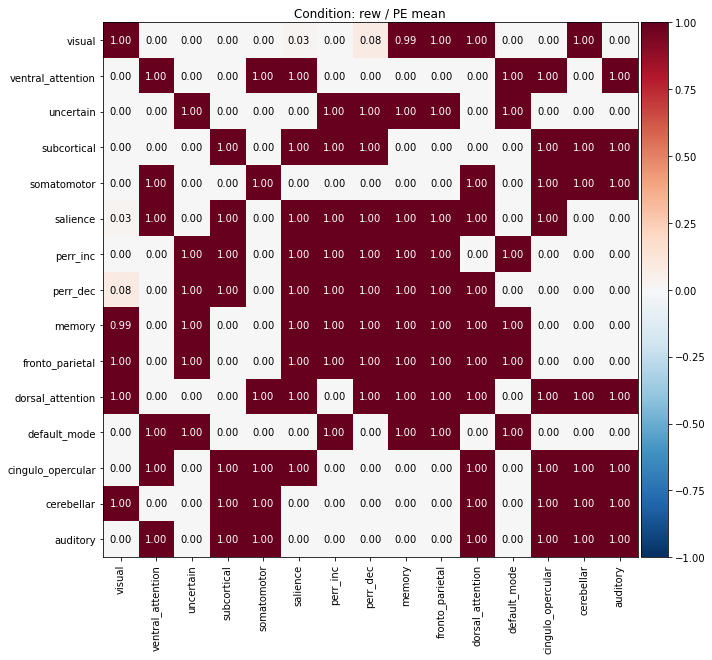

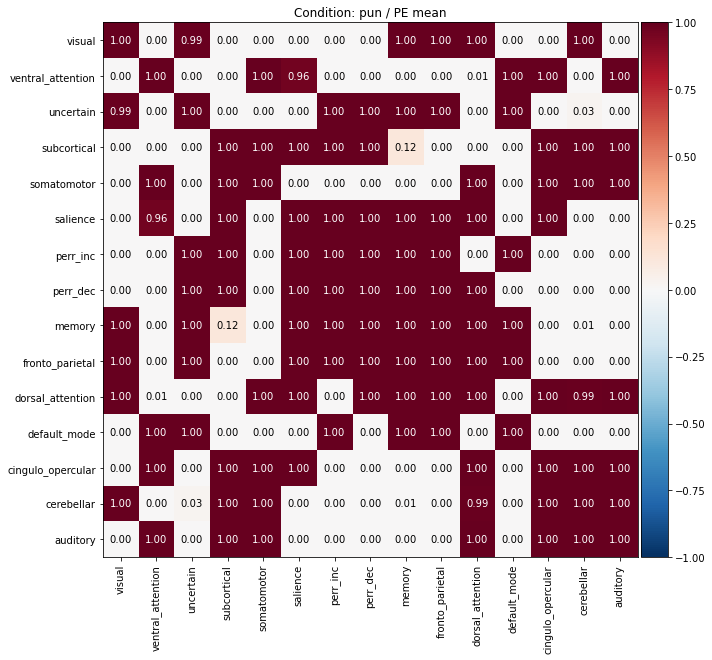

In [7]:
gtnull_pe = np.mean(lsn_aggregated[ok_index], axis=(0, 1)) \
       > np.swapaxes(np.mean(nulls_aggregated[ok_index], axis=(0, 1)), 0, 1)
gtnull_pe = np.sum(gtnull_pe, axis=0)
gtnull_pe = gtnull_pe / n_nulls

gtnull_con = np.mean(lsn_aggregated[ok_index], axis=(0, 2)) \
       > np.swapaxes(np.mean(nulls_aggregated[ok_index], axis=(0, 2)), 0, 1)
gtnull_con = np.sum(gtnull_con, axis=0)
gtnull_con = gtnull_con / n_nulls

for perr_sign_idx, perr_sign in enumerate(meta["dim3"]):
    plot_matrix(
        gtnull_pe[perr_sign_idx], 
        labels=netnames, 
        annotate=True, 
        title=f"Condition mean / PE: {perr_sign[-3:]}"
    )
    
for con_idx, con in enumerate(meta["dim2"]):
    plot_matrix(
        gtnull_con[con_idx], 
        labels=netnames, 
        annotate=True, 
        title=f"Condition: {con} / PE mean"
    )

## Entire task

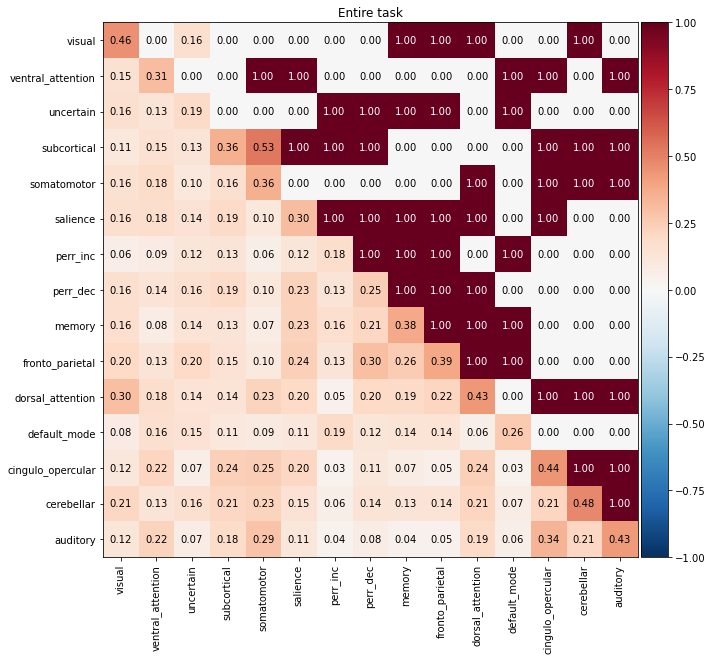

In [8]:
gtnull_all = np.mean(lsn_aggregated[ok_index], axis=(0, 1, 2)) \
           > np.mean(nulls_aggregated[ok_index], axis=(0, 1, 2))
gtnull_all = np.sum(gtnull_all, axis=0)
gtnull_all = gtnull_all / n_nulls

plot_matrix(
    np.triu(gtnull_all, k=1) + np.tril(np.mean(lsn_aggregated[ok_index], 
                                               axis=(0, 1, 2))), 
    labels=netnames, 
    annotate=True, 
    title=f"Entire task"
)

np.save(join(path_fdrthr, "pvalues_interactions.npy"), 1 - gtnull_all)